# Data fetching with polytope
Example for how to extract model level data from file/fdb/polytope and create a time-hight plots. Note that fdb is only available on ECMWF atos. To use polytope put your ECMWF web API key, https://api.ecmwf.int/v1/key/ in a ~/.polytopeapirc file as 

{
    "user_key"   : "some_hash",
    "user_email" : "foo.bar@somewhere.ok"
}


In [1]:
# Import necessary libraries
import os
import earthkit.data
import hashlib
from versions import UrbanAirData


In [2]:
# Define your input source as file, fdb or polytope
# Use CUSTOM_FILENAME with full path for file 
version = "8.0"
uad = UrbanAirData().urls[version]

INPUT_SOURCE = "polytope"   # use fdb for extraction on atos, polytope for external usage
CUSTOM_FILENAME = None
CUSTOM_FILEPATH = os.environ.get("SCRATCH", ".")
# Select a parameter from the list below
PARAM = "pt"
# Select top level to fetch. Lowest model level is 90 and top at 0.1 hPa is 1.

In [3]:
# Client authentification, use if required
#from polytope.api import Client
#client = Client(address=polytope_address)

In [4]:
# Define the request, note that we only extract levtop -> 90 levels to reduce the data amount
params = {
    "pt": 3,
    "pres": 54,
    "crw": 75,
    "cswc": 76,
    "z": 129,
    "t": 130,
    "u": 131,
    "v": 132,
    "q": 133,
    "clwc": 246,
    "ciwc": 247,
    "cc": 248,
    "grle": 260028,
    "tke": 260155,
    "wz": 260238,
    
}

request= {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "expver": uad["metadata"]["fdb"]["expver"],
    "stream": "oper",
    "date": uad["metadata"]["date"][:10],
    "time": uad["metadata"]["date"][12:18].replace(":",""),
    "type": "fc",
    "georef": uad["metadata"]["fdb"]["georef"],
    "levtype": "ml",
    "step": 0,
    "levelist": 1,
    "param": params[PARAM],
}

In [5]:
def check_fdb_env():
    # Make sure we have the correct FDB environment
    if INPUT_SOURCE == "fdb":
        os.environ["FDB_HOME"] = "/home/fdbtest"
    try:
        os.environ["FDB5_HOME"] = os.environ["ECMWF_TOOLBOX_DIR"]
    except:
        raise KeyError("Make sure to load ecmwf-toolbox before your start")

In [6]:
def construct_filename(request):
   # Construct the filename to cache
    
    key_list = []
    for key,x in request.items():
        if isinstance(x,str):
            key_list.append(x.replace("/","_"))
            #print(f"Add {key}={x}")
        elif isinstance(x,list):
            if any(not isinstance(y, str) for y in x):
               x = [str(y) for y in x]
            combined = "\0".join(x).encode("utf-8")
            hash = hashlib.sha1(combined).hexdigest()[:8]
            key_list.append(hash)
            #print(f"Hashed {key}={hash}")
    filename = "_".join(key_list) + ".grib2"
    data_target_path = f"{CUSTOM_FILEPATH}/{filename}"
    return data_target_path

In [7]:
def request_data(request):
    # Run the request
    print(request)
    data_target_path = construct_filename(request)
    if not os.path.isfile(data_target_path):
        if INPUT_SOURCE == "polytope":
            from polytope.api import Client
            client = Client(address=uad["metadata"]["polytope"]["url"])
            data = earthkit.data.from_source("polytope", uad["metadata"]["polytope"]["collection"], request, address=uad["metadata"]["polytope"]["url"], stream=False)
        elif INPUT_SOURCE == "fdb":
            check_fdb_env()
            data = earthkit.data.from_source("fdb", request, read_all=True)
        print("Save data to:", data_target_path)
        data.to_target("file", data_target_path)
    else:
        if CUSTOM_FILENAME is not None:
            data_target_path = CUSTOM_FILENAME
        print("Read:", data_target_path)
        data = earthkit.data.from_source("file", data_target_path)
    return data

In [8]:
def plot_map(x):
 chart = earthkit.plots.Map()
 chart.quickplot(x)
 chart.coastlines()
 chart.land()
 chart.borders()
 chart.gridlines()
 try:
    chart.legend()
 except:
    pass
 chart.show()

In [9]:
data = request_data(request)
data.ls()

{'class': 'd1', 'dataset': 'on-demand-extremes-dt', 'expver': 'aad4', 'stream': 'oper', 'date': '2023-08-20', 'time': '0000', 'type': 'fc', 'georef': 'u09tvk', 'levtype': 'ml', 'step': 0, 'levelist': 1, 'param': 3}
Read: /ec/res4/scratch/snh/d1_on-demand-extremes-dt_aad4_oper_2023-08-20_0000_fc_u09tvk_ml.grib2


,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,pt,hybrid,1,20230820,0,0s,fc,None,lambert_lam


In [10]:
# Extract A/B half levels from first GRIB message
a_and_b  = data.metadata("pv")[0]
l = len(a_and_b)//2
ahalf, bhalf = a_and_b[:l], a_and_b[l:]

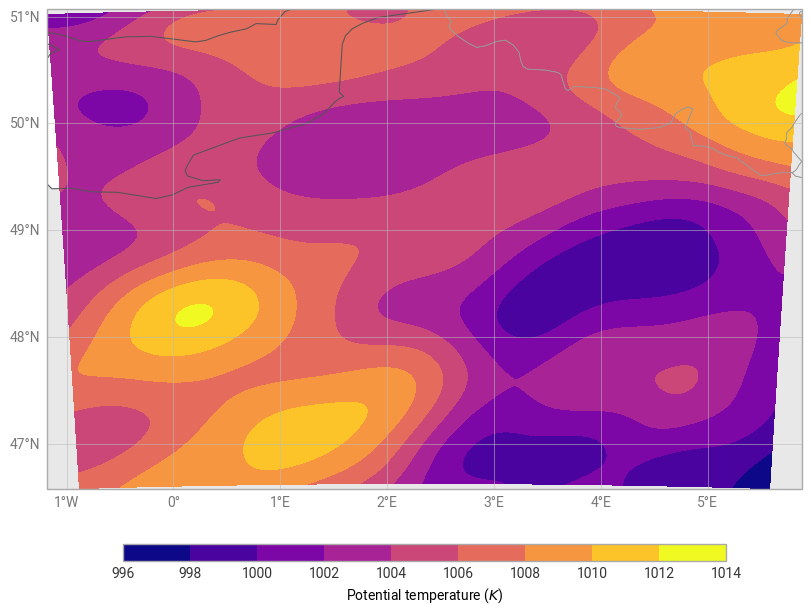

In [11]:
plot_map(data[0])